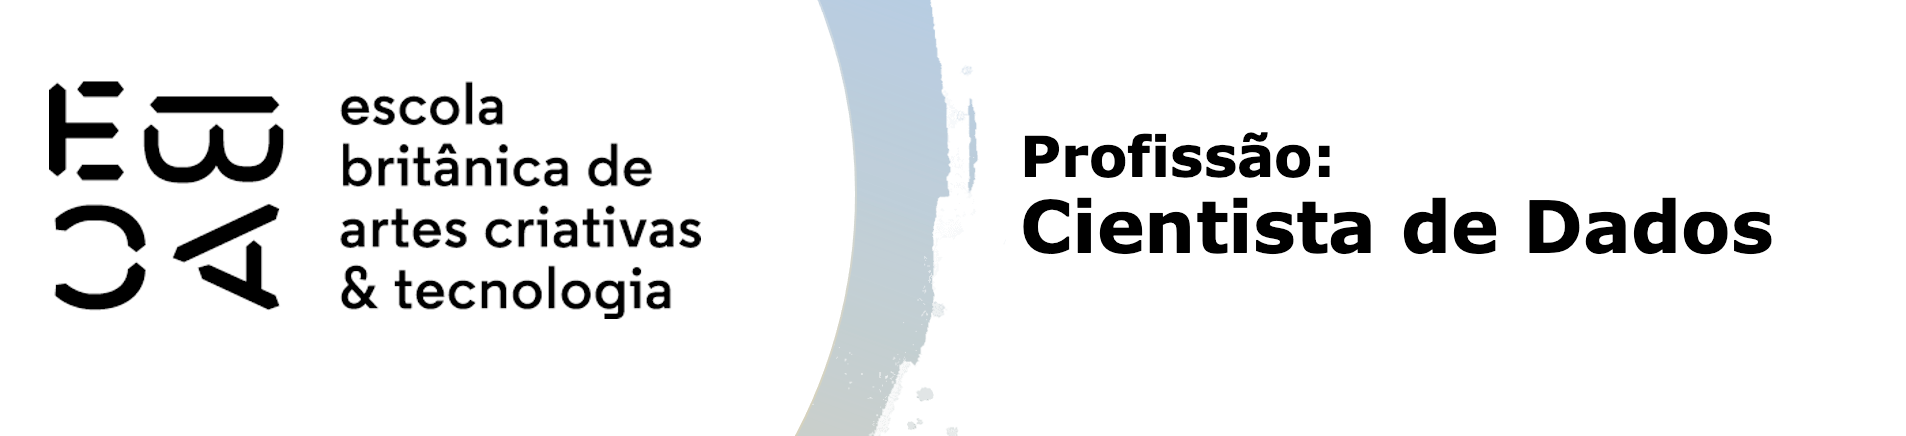

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle('./base_nfp.pkl')

df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [256]:
# Criando colunas com os respectivos dias da semana
df['Dia_da_semana'] = df['Data Registro'].dt.dayofweek

# Referente a semana do ano, sendo de 1 até 53
df['semana'] = df['Data Registro'].dt.isocalendar().week

# Referente ao nome do mês, de 1 a 12
df['mes'] = df['Data Registro'].dt.month

# Referente ao trimestre do respectivo mês, sendo de 1 até 4
df['trimestre'] = df['Data Registro'].dt.quarter

#Referente ao ano, de 2017 até 2022
df['ano'] = df['Data Registro'].dt.year


# Criar as variáveis por quantís de 5, 10, 20 e 50
for q in [5, 10, 20, 50]:
    df[f'ValorNF_q{q}'] = pd.qcut(df['Valor NF'], q, duplicates='drop')

df.head(3)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia_da_semana,semana,mes,trimestre,ano,ValorNF_q5,ValorNF_q10,ValorNF_q20,ValorNF_q50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Mercado,4,26,6,2,2017,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Auto posto,4,26,6,2,2017,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Restaurantes,4,26,6,2,2017,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [258]:
# Selecionei as colunas que, para esta análise, não trarão informações relevantes.
colunas_deletadas = ['CNPJ emit.', 'Emitente', 'No.', 'Data Registro', 'Data Emissão', 'Situação do Crédito']
                     
# Cópia do df original
new_df = df.copy()

# Função drop para excluir as colunas
new_df.drop(columns=colunas_deletadas, inplace=True)

# Transformando a categoria em dummies para analisar posteriormente
new_df = pd.get_dummies(new_df, columns=['categoria', ], dtype=int)

# Convertendo os quartis de NF para ponto médio, evita erros no loop do "popular metadados", visto que o qcut não identifica strings.
for col in ['ValorNF_q5', 'ValorNF_q10', 'ValorNF_q20', 'ValorNF_q50']:
    new_df[col] = new_df[col].apply(lambda x: x.mid if isinstance(x, pd.Interval) else np.nan)

# Criação do metadados através do new_df, pegando apenas o dtypes de cada coluna
metadados = pd.DataFrame({'dtypes':new_df.dtypes})

# Atribuindo papéis, ou seja, rótulos a cada variável. Resposta e Explicativas
metadados['papel'] = 'Explicativa'
metadados.loc['flag_credito', 'papel'] = 'Resposta'

# Atribuindo a quantidade de cada valor a cada
metadados['quantidade'] = new_df.nunique()

metadados

,dtypes,papel,quantidade
Valor NF,float64,Explicativa,33658
Créditos,float64,Explicativa,9717
Ano,int64,Explicativa,5
Semestre,int64,Explicativa,2
Retorno,float64,Explicativa,60202
flag_credito,int64,Resposta,2
Dia_da_semana,int32,Explicativa,7
semana,UInt32,Explicativa,53
mes,int32,Explicativa,12
trimestre,int32,Explicativa,4


In [259]:
# Função para calcular o IV
def IV (explicativa, resposta, eps=1e-6): # o eps serve para evitar erros de divisão por zero ou logaritmo de zero
  tab = pd.crosstab(explicativa,
           resposta,
           margins=True,
           margins_name='total')

  evento = tab.columns[0]
  nao_evento = tab.columns[1]

  tab['pct_evento'] = tab[evento]/tab.loc['total', evento]
  tab['pct_n_evento'] = tab[nao_evento]/tab.loc['total', nao_evento]

  # Adiciona epsilon para evitar log(0)
  tab['woe'] = np.log((tab['pct_evento'] + eps) / (tab['pct_n_evento'] + eps))
  tab['iv'] = (tab['pct_evento'] - tab['pct_n_evento']) * tab['woe']

  return tab['iv'].sum()

## Problemas com valores *inf*

Durante a execução da atividade, tive problemas com valores infinitos decorrentes da divisão por zero de alguma variável explicativa. Para sanar essa divergência, usei o conceito de ```epsilon```.

O ```epsilon``` é muito usado para evitar erros de divisão por zero ou logaritmos de zero. A ideia é substituir o suposto valor de zero por um número *extremamente muito pequeno*, praticamente insignificante.

$$
1 \times 10^{-6}
$$

```python
  tab['woe'] = np.log((tab['pct_evento'] + eps) / (tab['pct_n_evento'] + eps))
```

O ```epsilon``` foi usado no cálculo do **WOE**, justamente para evitar o $log(0)$ ou $1/0$. Isso garante que, se em algum grupo (ou faixa) o número de eventos for 0, o cálculo não quebre e o logaritmo não seja infinito.

In [277]:
# Função para popular o metadados com o IV

for var in metadados[metadados['papel'] == 'Explicativa'].index:
    try:
        serie = new_df[var]
        if pd.api.types.is_numeric_dtype(serie):
            if metadados.loc[var, 'quantidade'] > 5:
                metadados.loc[var, 'iv'] = IV(pd.qcut(serie, 5, duplicates='drop'),
                                              new_df['flag_credito'])
            else:
                metadados.loc[var, 'iv'] = IV(serie, new_df['flag_credito'])
        elif isinstance(serie.dtype, pd.CategoricalDtype):
            metadados.loc[var, 'iv'] = IV(serie, new_df['flag_credito'])
        else:
            print(f"Coluna ignorada (tipo não tratado): {var}")
            metadados.loc[var, 'iv'] = np.nan
    except Exception as e:
        print(f"Erro em {var}: {e}")
        metadados.loc[var, 'iv'] = np.nan

metadados

,dtypes,papel,quantidade,iv
Valor NF,float64,Explicativa,33658,0.056694
Créditos,float64,Explicativa,9717,13.017521
Ano,int64,Explicativa,5,0.041651
Semestre,int64,Explicativa,2,0.001258
Retorno,float64,Explicativa,60202,13.346196
flag_credito,int64,Resposta,2,NaN
Dia_da_semana,int32,Explicativa,7,0.013062
semana,UInt32,Explicativa,53,0.003600
mes,int32,Explicativa,12,0.006106
trimestre,int32,Explicativa,4,0.004030


## Comentando o código

A fim de não poluir a célula, farei aqui os comentários sobre o código.

---


É realizado o cálculo do IV apenas nas variáveis **Explicativa**
```python
for var in metadados[metadados['papel'] == 'Explicativa'].index:
```

---

Dentro deste bloco, o código pega a coluna correspondente (*var*) no DataFrame ```new_df``` e guarda no objeto *serie*
```python
try:
        serie = new_df[var]
```

---

Essa linha é demasiada importante, pois verifica se a coluna armazenada na ```serie``` é numérica (*int* ou *float*). O método de cálculo do **IV** muda conforme o tipo da variável.
```python
        if pd.api.types.is_numeric_dtype(serie):
```

---

Acessa a coluna *'quantidade'*, se o valor for **maior** que 5, fará o comanda da linha seguinte: fatiamento em 5 bins usando o ```qcut```.
```python
            if metadados.loc[var, 'quantidade'] > 5:
                metadados.loc[var, 'iv'] = IV(pd.qcut(serie, 5, duplicates='drop'),
                                              new_df['flag_credito'])
```

---

Se a variável for ```numérica``` e tiver poucos valores (**<5**), ela não será cortada em faixas e será aplicada a função *IV* diretamente
```python
            else:
                metadados.loc[var, 'iv'] = IV(serie, new_df['flag_credito'])
```

---

Essa parte trata das variáveis ```categóricas```. Usa a função **isinstance** para verificar se o tipo da série é categórico e aplica diretamente a função *IV*.
```python
        elif isinstance(serie.dtype, pd.CategoricalDtype):
            metadados.loc[var, 'iv'] = IV(serie, new_df['flag_credito'])
```

---

Esse bloco está dedicado a identificação de possíveis erros. Caso a variável não seja numérica nem categórica, ela é ignorada e o código imprime uma mensagem informando o nome da coluna.
```python
        else:
            print(f"Coluna ignorada (tipo não tratado): {var}")
            metadados.loc[var, 'iv'] = np.nan
```

---

Se qualquer erro acontecer dentro desse bloco, o código não para. Ele imprime o nome da variável com erro e armazena ```NaN``` no *IV*.
```python        
        except Exception as e:
        print(f"Erro em {var}: {e}")
        metadados.loc[var, 'iv'] = np.nan
```

---

Exibi o DataFrame atualizado
```python
metadados

```

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?

|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

As variáveis ```Retorno``` e ```Créditos``` apresentam valores **extremamente alto**, são valores suspeitos de acordo com a tabela de Siddiqi. Isso pode indicar duas situações:
1) Tem informação vazada
2) Contém a resposta embutida

A variável ```categoria_Alimentos``` tem um poder *médio alto*, chegando a quase *0,3*.

As variáveis categorizadas ```ValorNF_50```, ```ValorNF_20``` e ```ValorNF_10``` possuem valor **médio**, ficando entre *0,15* e *0,10*.

---

### Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

À medida que aumenta o número de categorias do ValorNF, o **IV cresce**. Isso ocorre porque o particionamento mais fino aumenta a granularidade da informação, ou seija, o modelo passa a captar melhor as diferenças entre grupos.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

### A quantidade de notas registradas na base por período


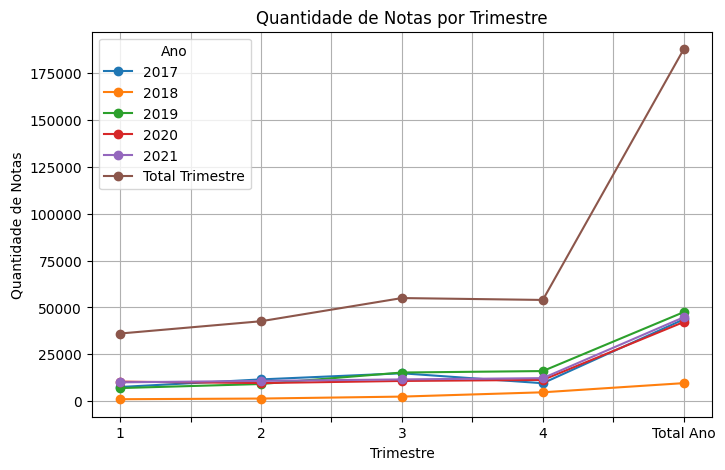

Ano,2017,2018,2019,2020,2021,Total Trimestre
trimestre,,,,,,
1,7561,1043,6983,10431,10053,36071
2,11607,1401,9154,9653,10807,42622
3,14868,2440,15283,10784,11604,54979
4,9572,4735,16055,11332,12280,53974
Total Ano,43608,9619,47475,42200,44744,187646


In [420]:
notas_trimestre = new_df.groupby(['trimestre', 'Ano']).size().unstack()

# Soma por linha (total por trimestre)
notas_trimestre['Total Trimestre'] = notas_trimestre.sum(axis=1)

# Soma por coluna (total por ano)
notas_trimestre.loc['Total Ano'] = notas_trimestre.sum(axis=0)


# Gráfico
notas_trimestre.plot(kind='line', marker='o', figsize=(8,5))
plt.title('Quantidade de Notas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.grid(True)
plt.show()

notas_trimestre

### A quantidade de notas por categoria e por período


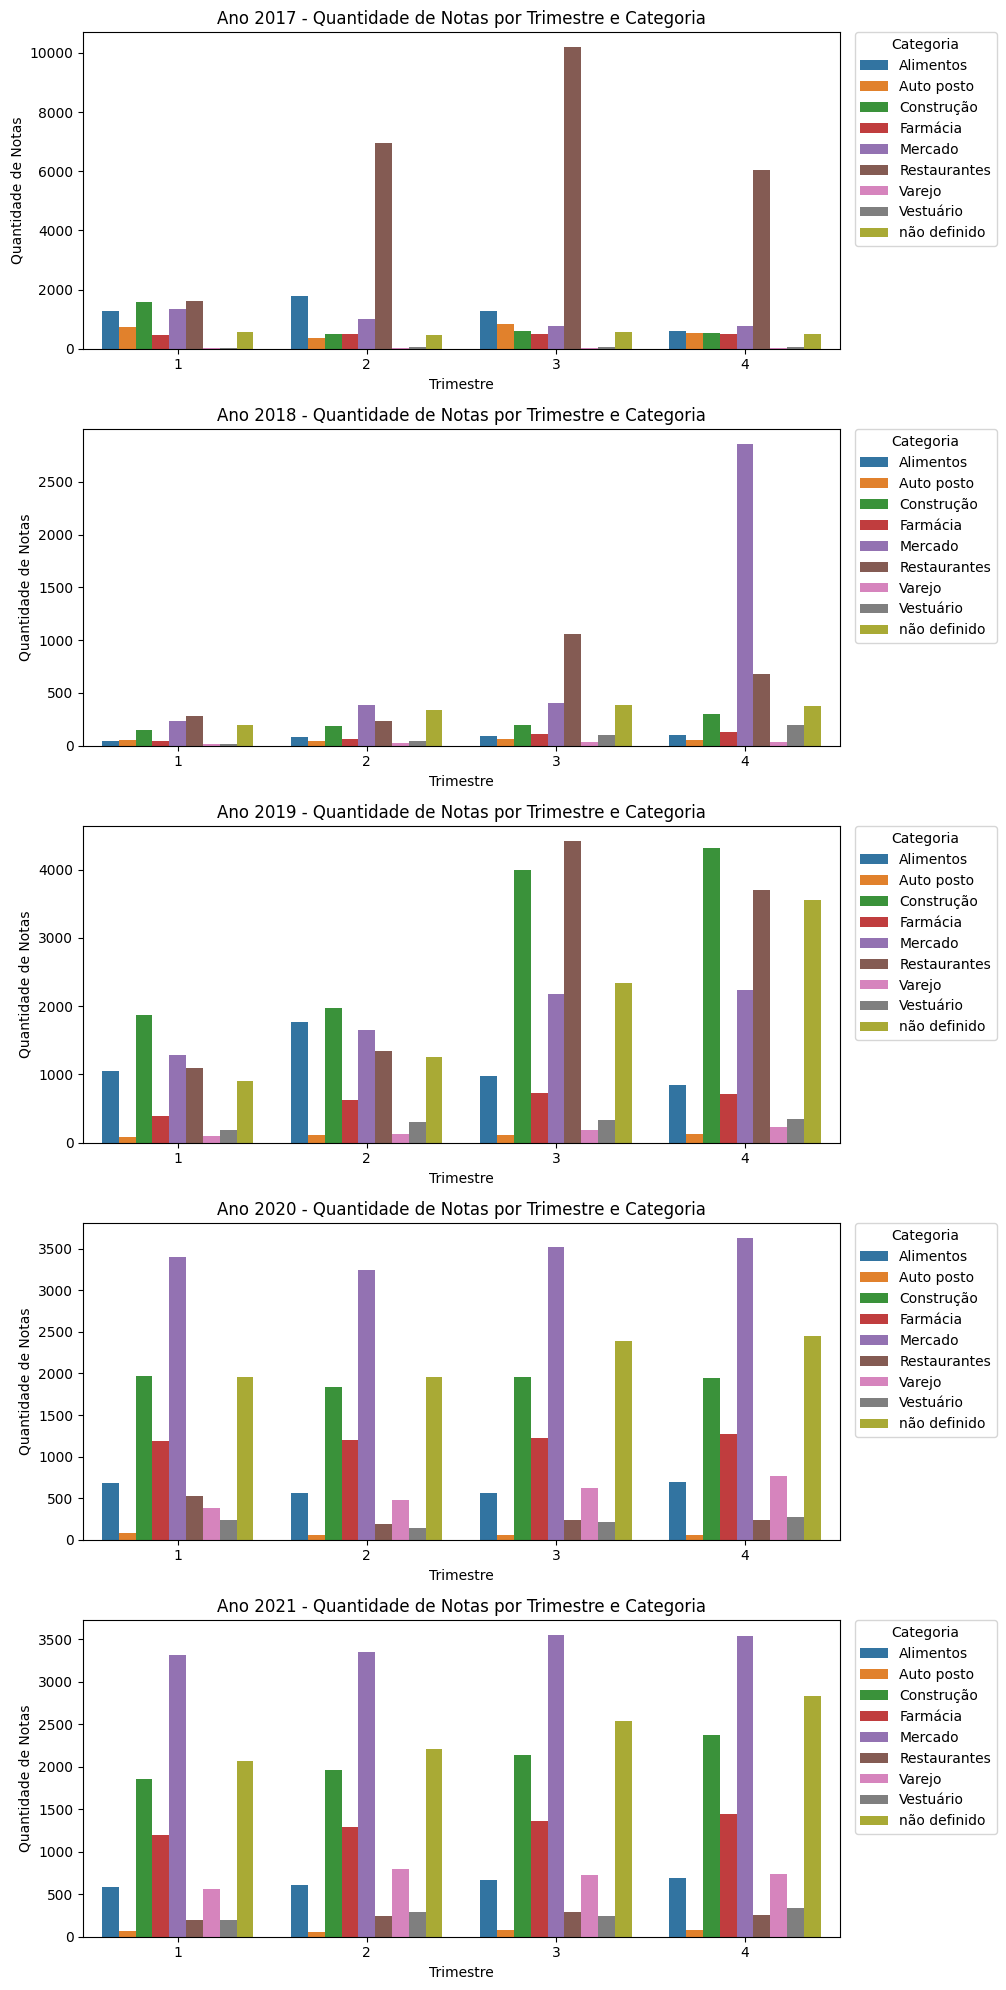

In [424]:
# Contagem de notas por trimestre/Ano
notas_categoria = (
    df.groupby(['trimestre', 'Ano', 'categoria'])
    .size()
    .reset_index(name='qtd')
)

# Criar uma figura com 4 subplots (um para cada ano)
anos = sorted(notas_categoria['Ano'].unique())
fig, axes = plt.subplots(nrows=len(anos), ncols=1, figsize=(12, 4 * len(anos)))

for i, ano in enumerate(anos):
    ax = axes[i]
    df_ano = notas_categoria[notas_categoria['Ano'] == ano]

    sns.barplot(
        data=df_ano,
        x='trimestre',
        y='qtd',
        hue='categoria',
        ax=ax
    )

    ax.set_title(f'Ano {ano} - Quantidade de Notas por Trimestre e Categoria')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Quantidade de Notas')

    # Ajuste da legenda
    ax.legend(
        title='Categoria',
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0
    )

# Ajustar espaçamento vertical e reservar espaço à direita
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

### A proporção de notas com crédito por categoria por período

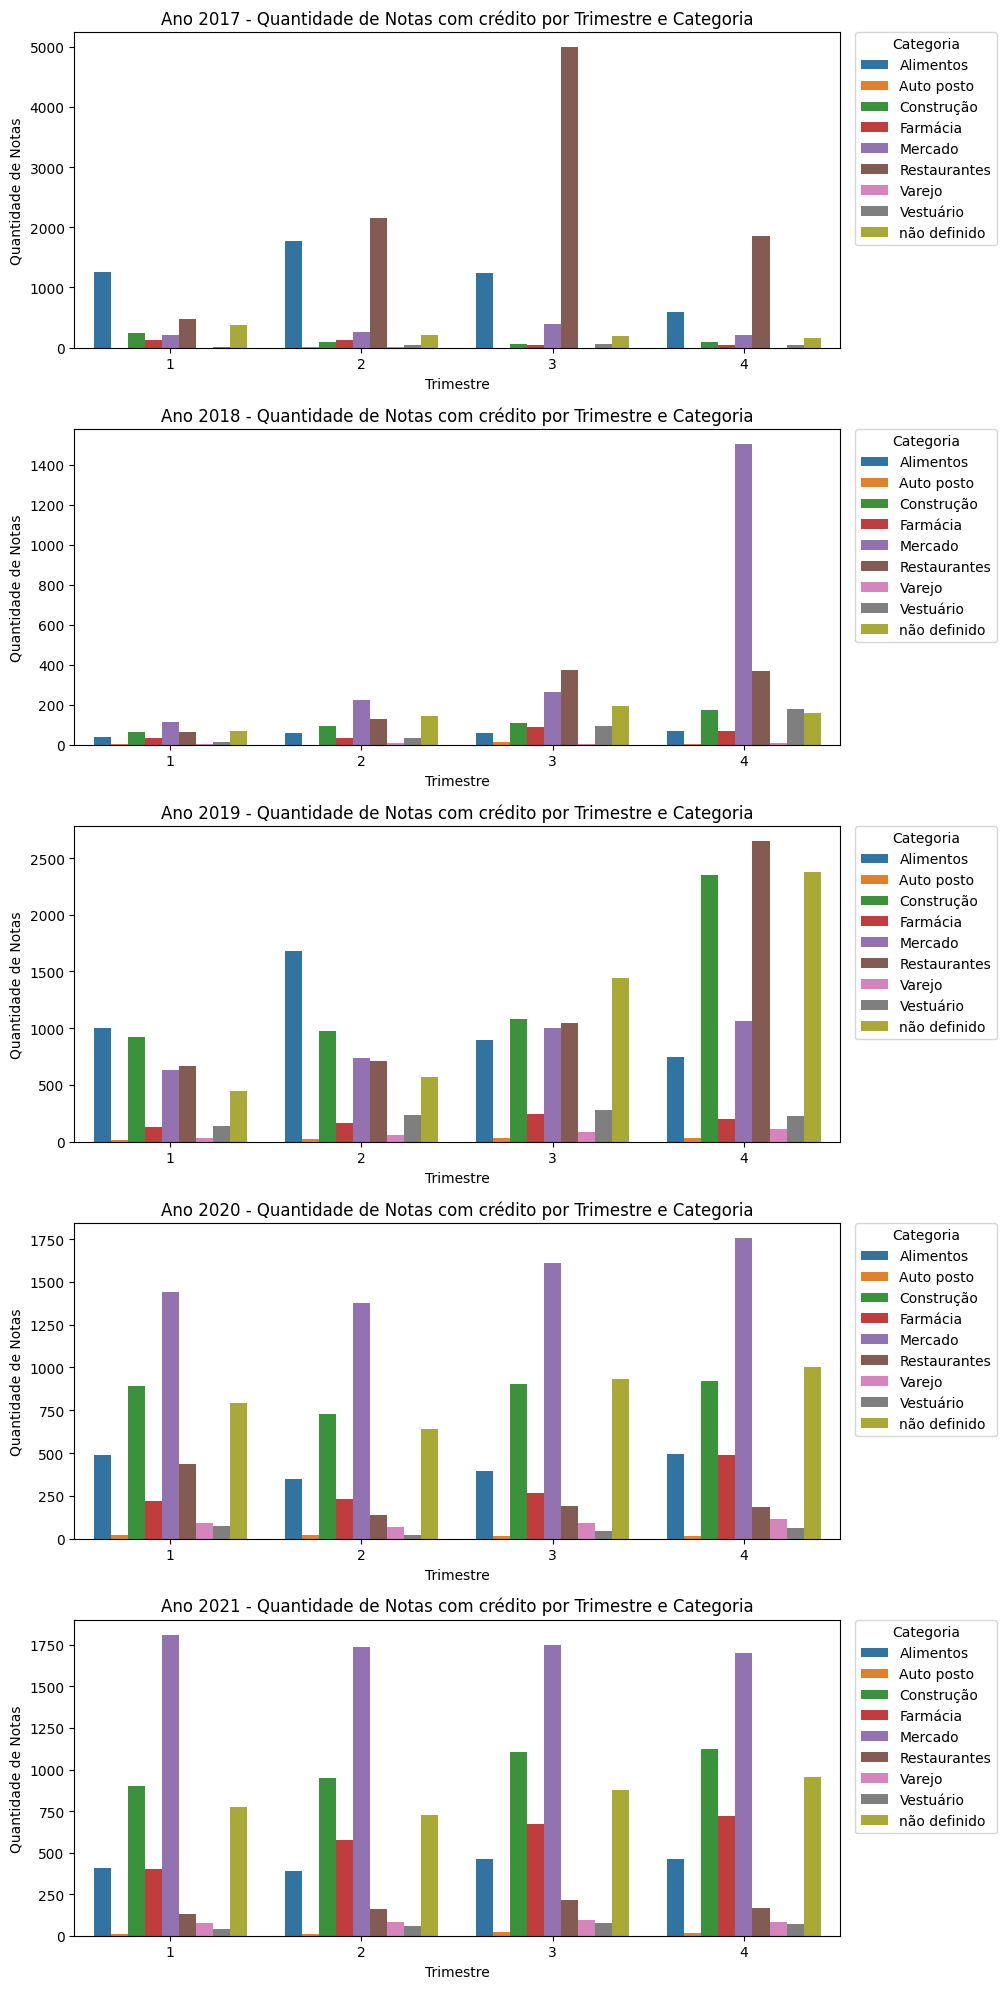

In [430]:
# Filtrando o DF com as notas com crédito
df_filtrado = df[df['flag_credito'] == 1]

# Contagem de notas por trimestre/Ano
notas_categoria_credito = (
    df_filtrado.groupby(['trimestre', 'Ano', 'categoria'])
    .size()
    .reset_index(name='qtd')
)

# Criar uma figura com 4 subplots (um para cada ano)
anos = sorted(notas_categoria_credito['Ano'].unique())
fig, axes = plt.subplots(nrows=len(anos), ncols=1, figsize=(12, 4 * len(anos)))

for i, ano in enumerate(anos):
    ax = axes[i]
    df_ano = notas_categoria_credito[notas_categoria_credito['Ano'] == ano]

    sns.barplot(
        data=df_ano,
        x='trimestre',
        y='qtd',
        hue='categoria',
        ax=ax
    )

    ax.set_title(f'Ano {ano} - Quantidade de Notas com crédito por Trimestre e Categoria')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Quantidade de Notas')

    # Ajuste da legenda
    ax.legend(
        title='Categoria',
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0
    )

# Ajustar espaçamento vertical e reservar espaço à direita
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [539]:
df_filtrado = df[df['ano'] >= 2020]
variaveis_para_df = ['categoria', 'trimestre', 'ano', 'flag_credito']

df_cat = df_filtrado[variaveis_para_df]


# Transformando a categoria em dummies para analisar posteriormente
df_cat = pd.get_dummies(df_cat, columns=['categoria', 'trimestre', 'ano'], dtype=int)

# Criação do metadados através do new_df, pegando apenas o dtypes de cada coluna
new_metadados = pd.DataFrame({'dtypes':df_cat.dtypes})

# Atribuindo papéis, ou seja, rótulos a cada variável. Resposta e Explicativas
new_metadados['papel'] = 'Explicativa'
new_metadados.loc['flag_credito', 'papel'] = 'Resposta'

# Atribuindo a quantidade de cada valor a cada
new_metadados['quantidade'] = df_cat.nunique()

new_metadados

,dtypes,papel,quantidade
flag_credito,int64,Resposta,2
categoria_Alimentos,int32,Explicativa,2
categoria_Auto posto,int32,Explicativa,2
categoria_Construção,int32,Explicativa,2
categoria_Farmácia,int32,Explicativa,2
categoria_Mercado,int32,Explicativa,2
categoria_Restaurantes,int32,Explicativa,2
categoria_Varejo,int32,Explicativa,2
categoria_Vestuário,int32,Explicativa,2
categoria_não definido,int32,Explicativa,2


In [541]:
for var in new_metadados[new_metadados['papel'] == 'Explicativa'].index:
    try:
        serie = df_cat[var]
        if pd.api.types.is_numeric_dtype(serie):
            if new_metadados.loc[var, 'quantidade'] > 5:
                new_metadados.loc[var, 'iv'] = IV(pd.qcut(serie, 5, duplicates='drop'),
                                              df_cat['flag_credito'])
            else:
                new_metadados.loc[var, 'iv'] = IV(serie, df_cat['flag_credito'])
        elif isinstance(serie.dtype, pd.CategoricalDtype):
            new_metadados.loc[var, 'iv'] = IV(serie, df_cat['flag_credito'])
        else:
            print(f"Coluna ignorada (tipo não tratado): {var}")
            new_metadados.loc[var, 'iv'] = np.nan
    except Exception as e:
        print(f"Erro em {var}: {e}")
        new_metadados.loc[var, 'iv'] = np.nan

new_metadados

,dtypes,papel,quantidade,iv
flag_credito,int64,Resposta,2,NaN
categoria_Alimentos,int32,Explicativa,2,0.066433
categoria_Auto posto,int32,Explicativa,2,0.003727
categoria_Construção,int32,Explicativa,2,0.005840
categoria_Farmácia,int32,Explicativa,2,0.013729
categoria_Mercado,int32,Explicativa,2,0.018210
categoria_Restaurantes,int32,Explicativa,2,0.045703
categoria_Varejo,int32,Explicativa,2,0.111633
categoria_Vestuário,int32,Explicativa,2,0.016809
categoria_não definido,int32,Explicativa,2,0.019385


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

In [475]:
new_metadados.sort_values(by='iv', ascending=False)

,dtypes,papel,quantidade,iv
categoria_Varejo,int32,Explicativa,2,0.111633
categoria_Alimentos,int32,Explicativa,2,0.066433
categoria_Restaurantes,int32,Explicativa,2,0.045703
categoria_não definido,int32,Explicativa,2,0.019385
categoria_Mercado,int32,Explicativa,2,0.018210
categoria_Vestuário,int32,Explicativa,2,0.016809
categoria_Farmácia,int32,Explicativa,2,0.013729
categoria_Construção,int32,Explicativa,2,0.005840
categoria_Auto posto,int32,Explicativa,2,0.003727
trimestre_2,int32,Explicativa,2,0.003488


|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

### Quais categorias parece ter maior proporção de notas com retornos maiores que zero?

Dentre as categorias, destaco a ```Varejo``` com poder preditivo médio, valor de *0,111*, ```Alimentos``` e ```Restaurantes``` com poder preditivo fraco com, respectivamente, *0,0664* e *0,0457*. As outras categorias apresentam impacto menor, tornando-as inúteis neste contexto.

### Essas diferenças são estáveis no tempo?

Não há variações significativas por trimestre ou ano, demonstrando que o comportamento da ```flag_credito``` é estável no tempo para o período de 2020-2022.

O **IV** permanece muito baixo durante o período, isso justifica a *estabilidade temporal* na proporção de notas com crédito positivo (1).

Especificamente para o ano de 2022, percebi um declive acentuado, mas deduzo que seja falta ou menor volume de dados.